<a href="https://colab.research.google.com/github/Nikhil-4-Pal/Fraud-Detection-with-Explainable-AI/blob/main/Fraud_Detection_with_Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d18a0f775191c671bf47385dd717be459349dc963b9db0fb36a53be3c38ef9f5
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import sqlite3

df = pd.read_csv('creditcard.csv')
conn = sqlite3.connect('fraud_data.db')
df.to_sql('transactions',conn , if_exists='replace', index=False)

284807

In [ ]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
query = """
SELECT
      Class,
      Count(Class) as num_transactions,
      AVG(Amount) as avg_amount,
      SUM(Amount) as total_amount
FROM
      transactions
GROUP BY
      Class;
"""

df_summary = pd.read_sql_query(query , conn)
print(df_summary)
df = pd.read_sql_query("SELECT * FROM transactions",conn)
conn.close()

   Class  num_transactions  avg_amount  total_amount
0      0            284315   88.291022  2.510246e+07
1      1               492  122.211321  6.012797e+04


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
print('The Number of Missing Values :',df.isnull().sum().any())

The Number of Missing Values : False


In [ ]:
print("Descriptive Analysis")
print(df.describe())

Descriptive Analysis
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  

# Understanding the Class Imbalance

Non-Fraudulent (0): 284315 transactions (99.8273%)
Fraudulent (1):     492 transactions (0.1727%)


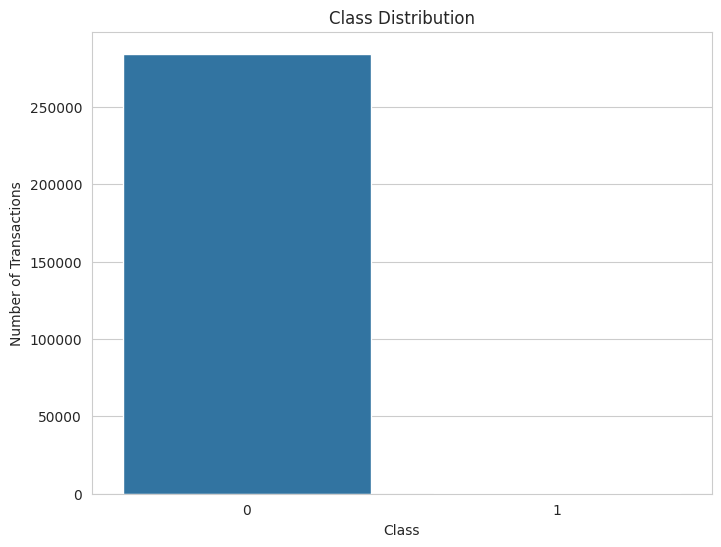

In [ ]:
class_counts = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True)*100

print(f"Non-Fraudulent (0): {class_counts[0]} transactions ({class_percentage[0]:.4f}%)")
print(f"Fraudulent (1):     {class_counts[1]} transactions ({class_percentage[1]:.4f}%)")

plt.figure(figsize=(8,6))
sns.countplot(x='Class',data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

# Looking a Little Closer to Time and Amount

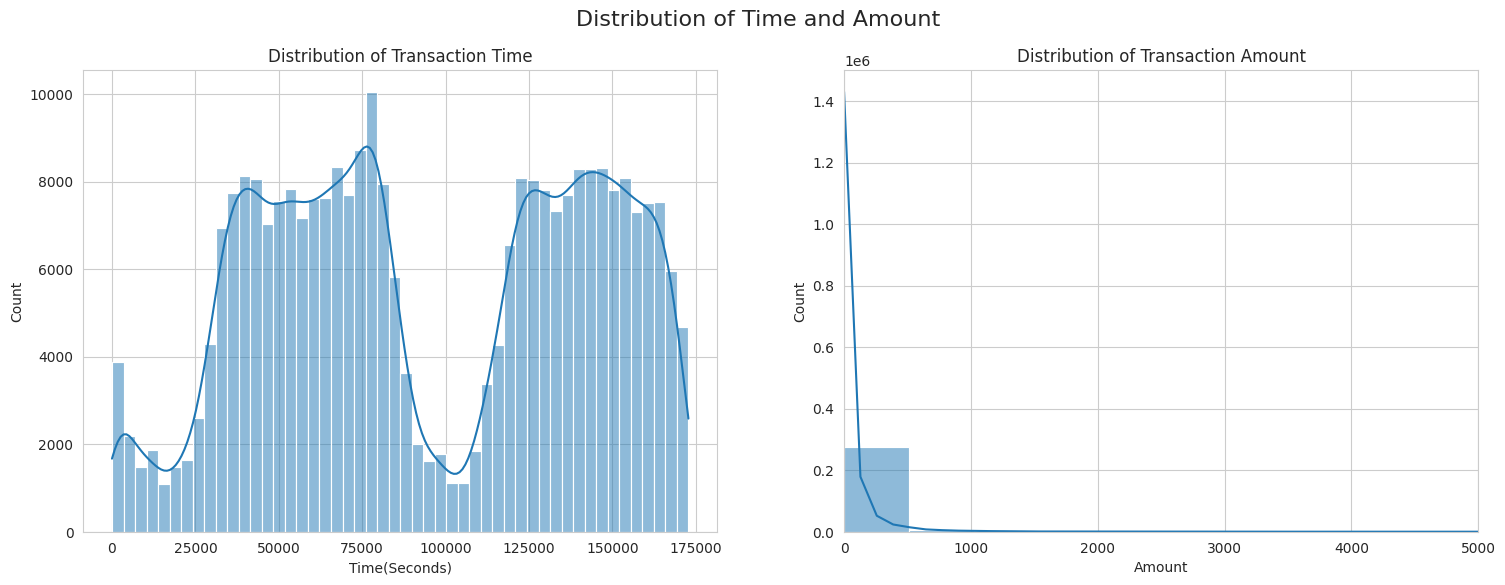

<function matplotlib.pyplot.show(close=None, block=None)>

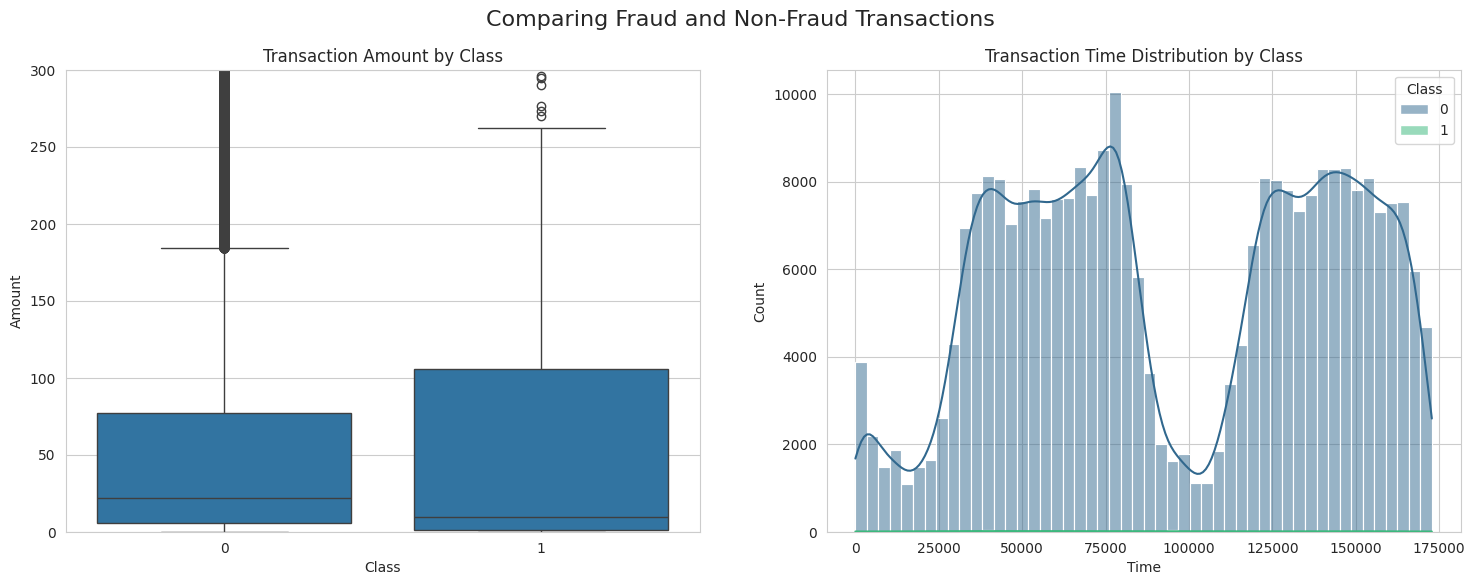

In [ ]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))

sns.histplot(df['Time'],bins=50,kde=True,ax=ax1)
ax1.set_title('Distribution of Transaction Time')
ax1.set_xlabel('Time(Seconds)')

sns.histplot(df['Amount'],bins=50,kde=True,ax=ax2)
ax2.set_title('Distribution of Transaction Amount')
ax2.set_xlabel('Amount')
ax2.set_xlim(0,5000)

plt.suptitle('Distribution of Time and Amount',fontsize=16)
plt.show()

fig, (ax3,ax4) = plt.subplots(1,2,figsize=(18,6))

sns.boxplot(x='Class', y='Amount', data=df, ax=ax3)
ax3.set_title('Transaction Amount by Class')
ax3.set_ylim(0,300)

sns.histplot(data=df,x='Time',hue='Class',bins=50,kde=True,multiple='stack',palette='viridis')
ax4.set_title('Transaction Time Distribution by Class')

plt.suptitle('Comparing Fraud and Non-Fraud Transactions',fontsize=16)
plt.show

# Let's Analyze anonymous features

/tmp/ipython-input-3349429582.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


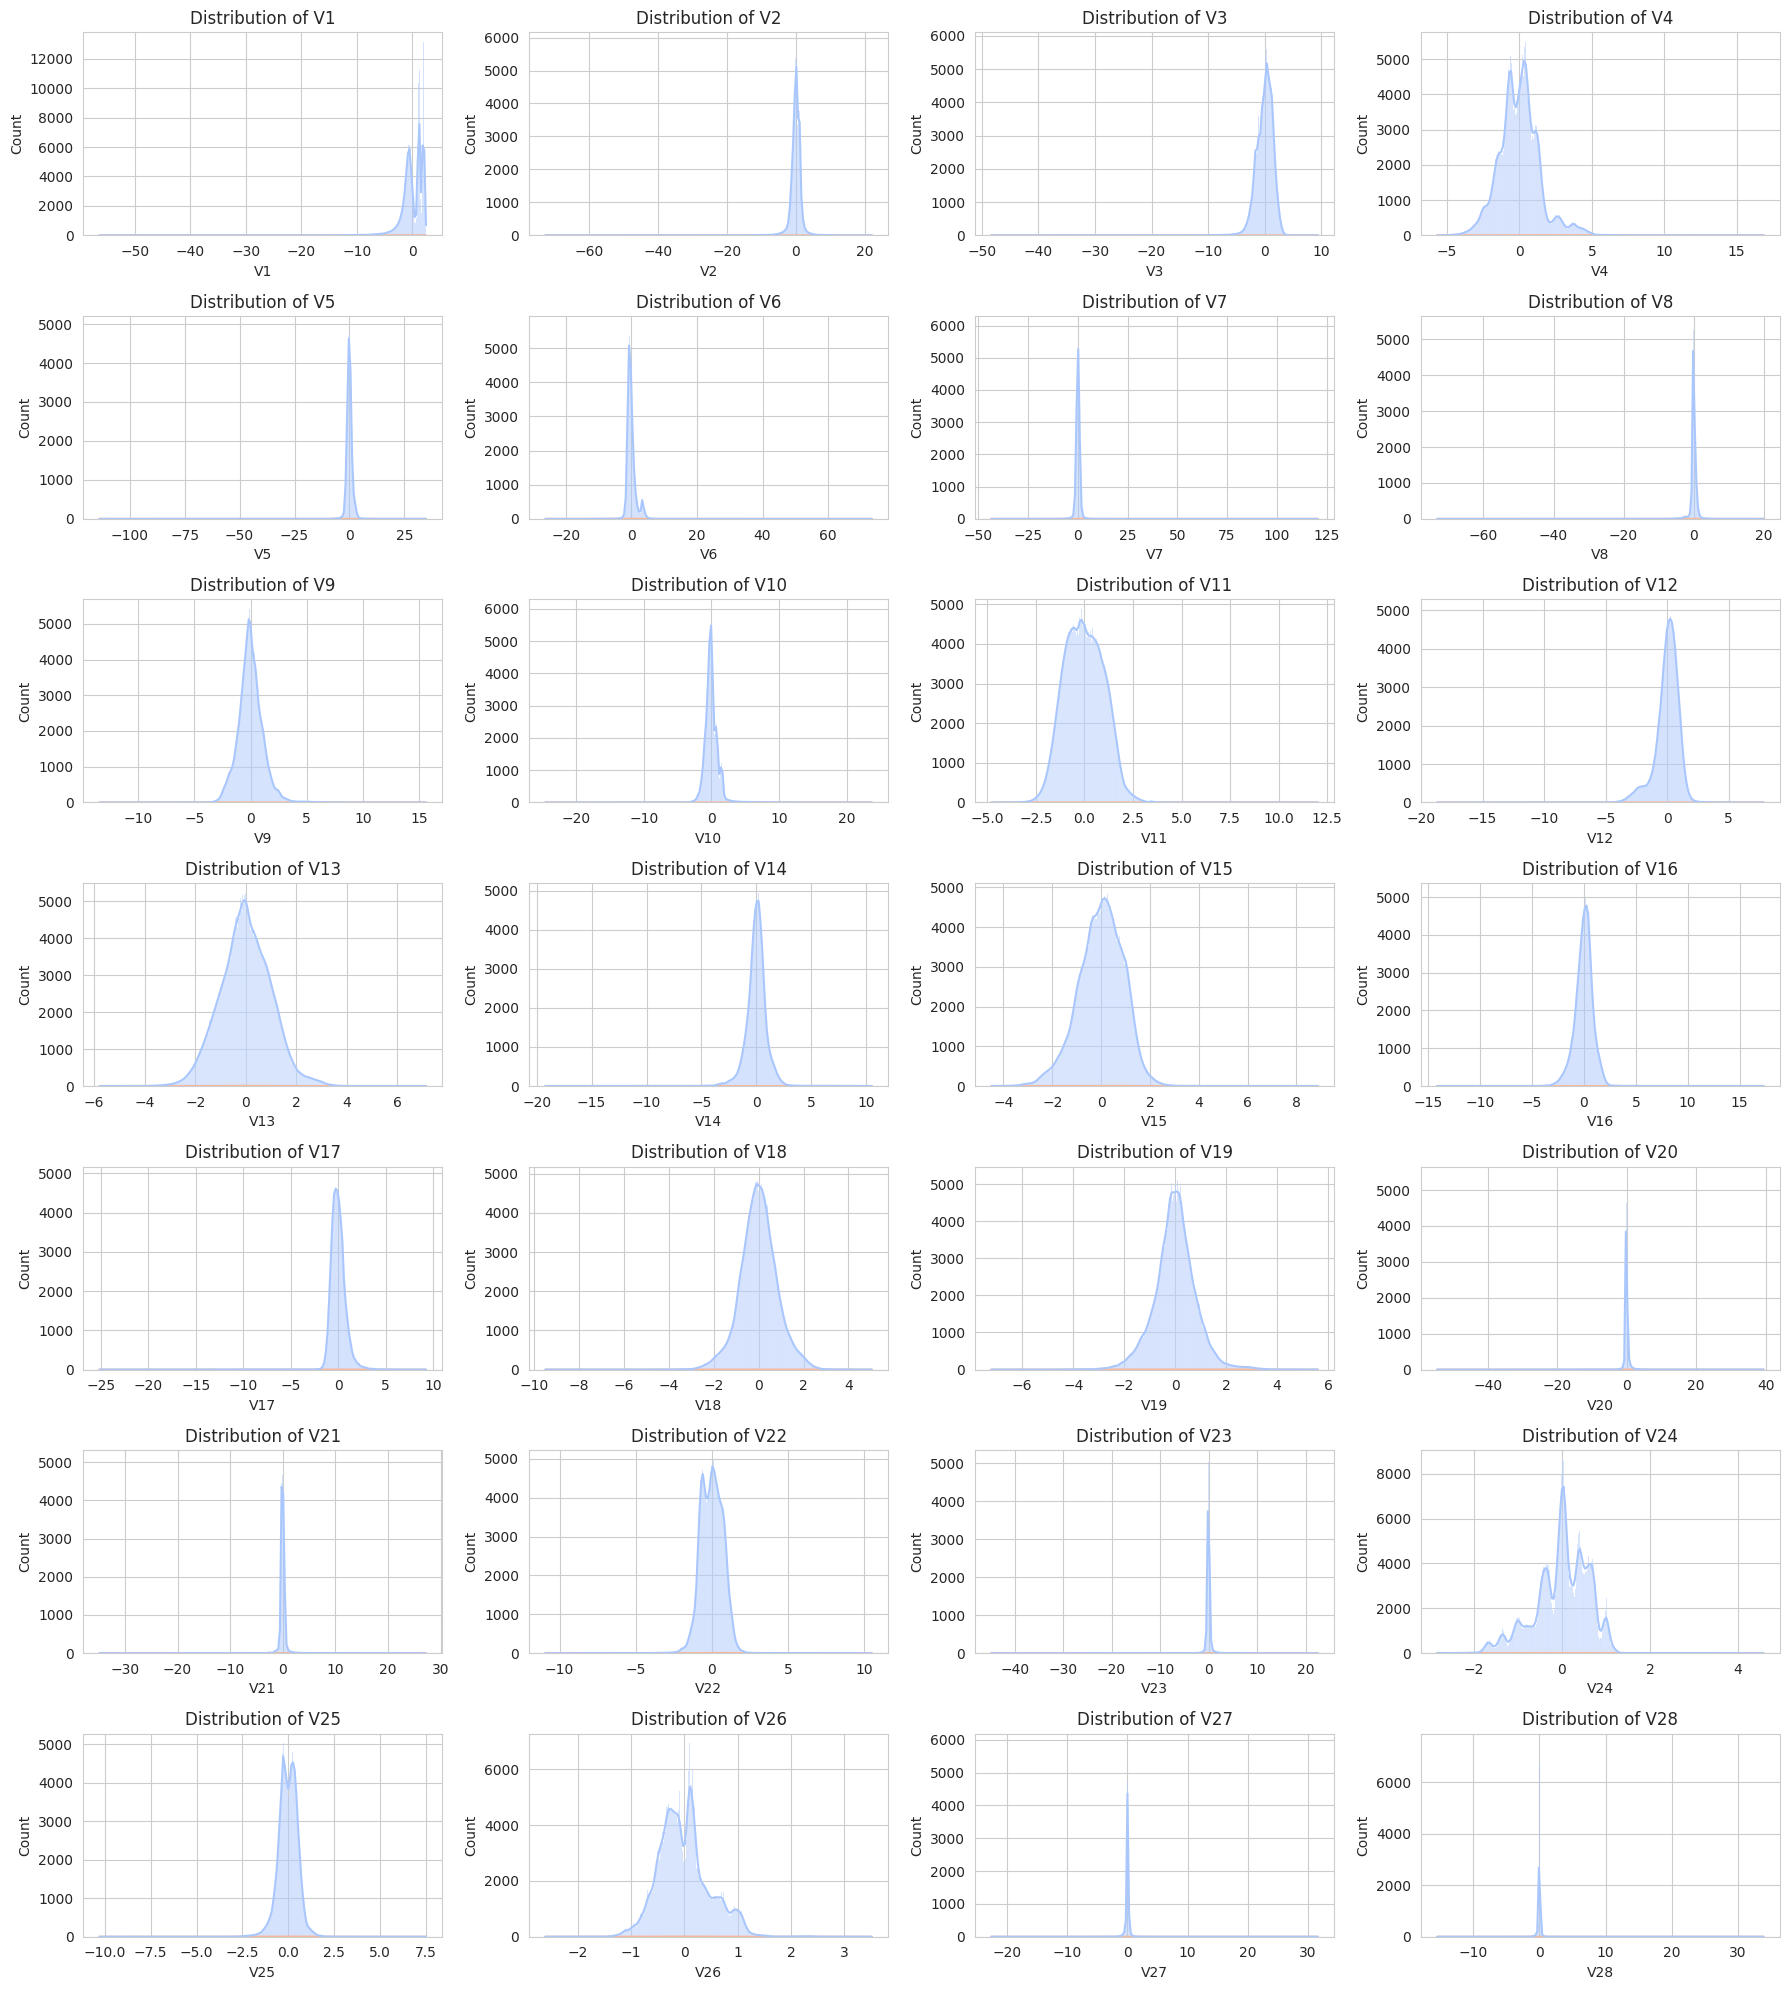

In [ ]:
v_features = df.iloc[:,1:29].columns

plt.figure(figsize=(18,20))

for i, col in enumerate(v_features):
  plt.subplot(7, 4, i+1)
  sns.histplot(df, x=col, hue='Class', kde=True, palette='coolwarm')
  plt.title(f'Distribution of {col}')
  plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

# Correlation Analysis

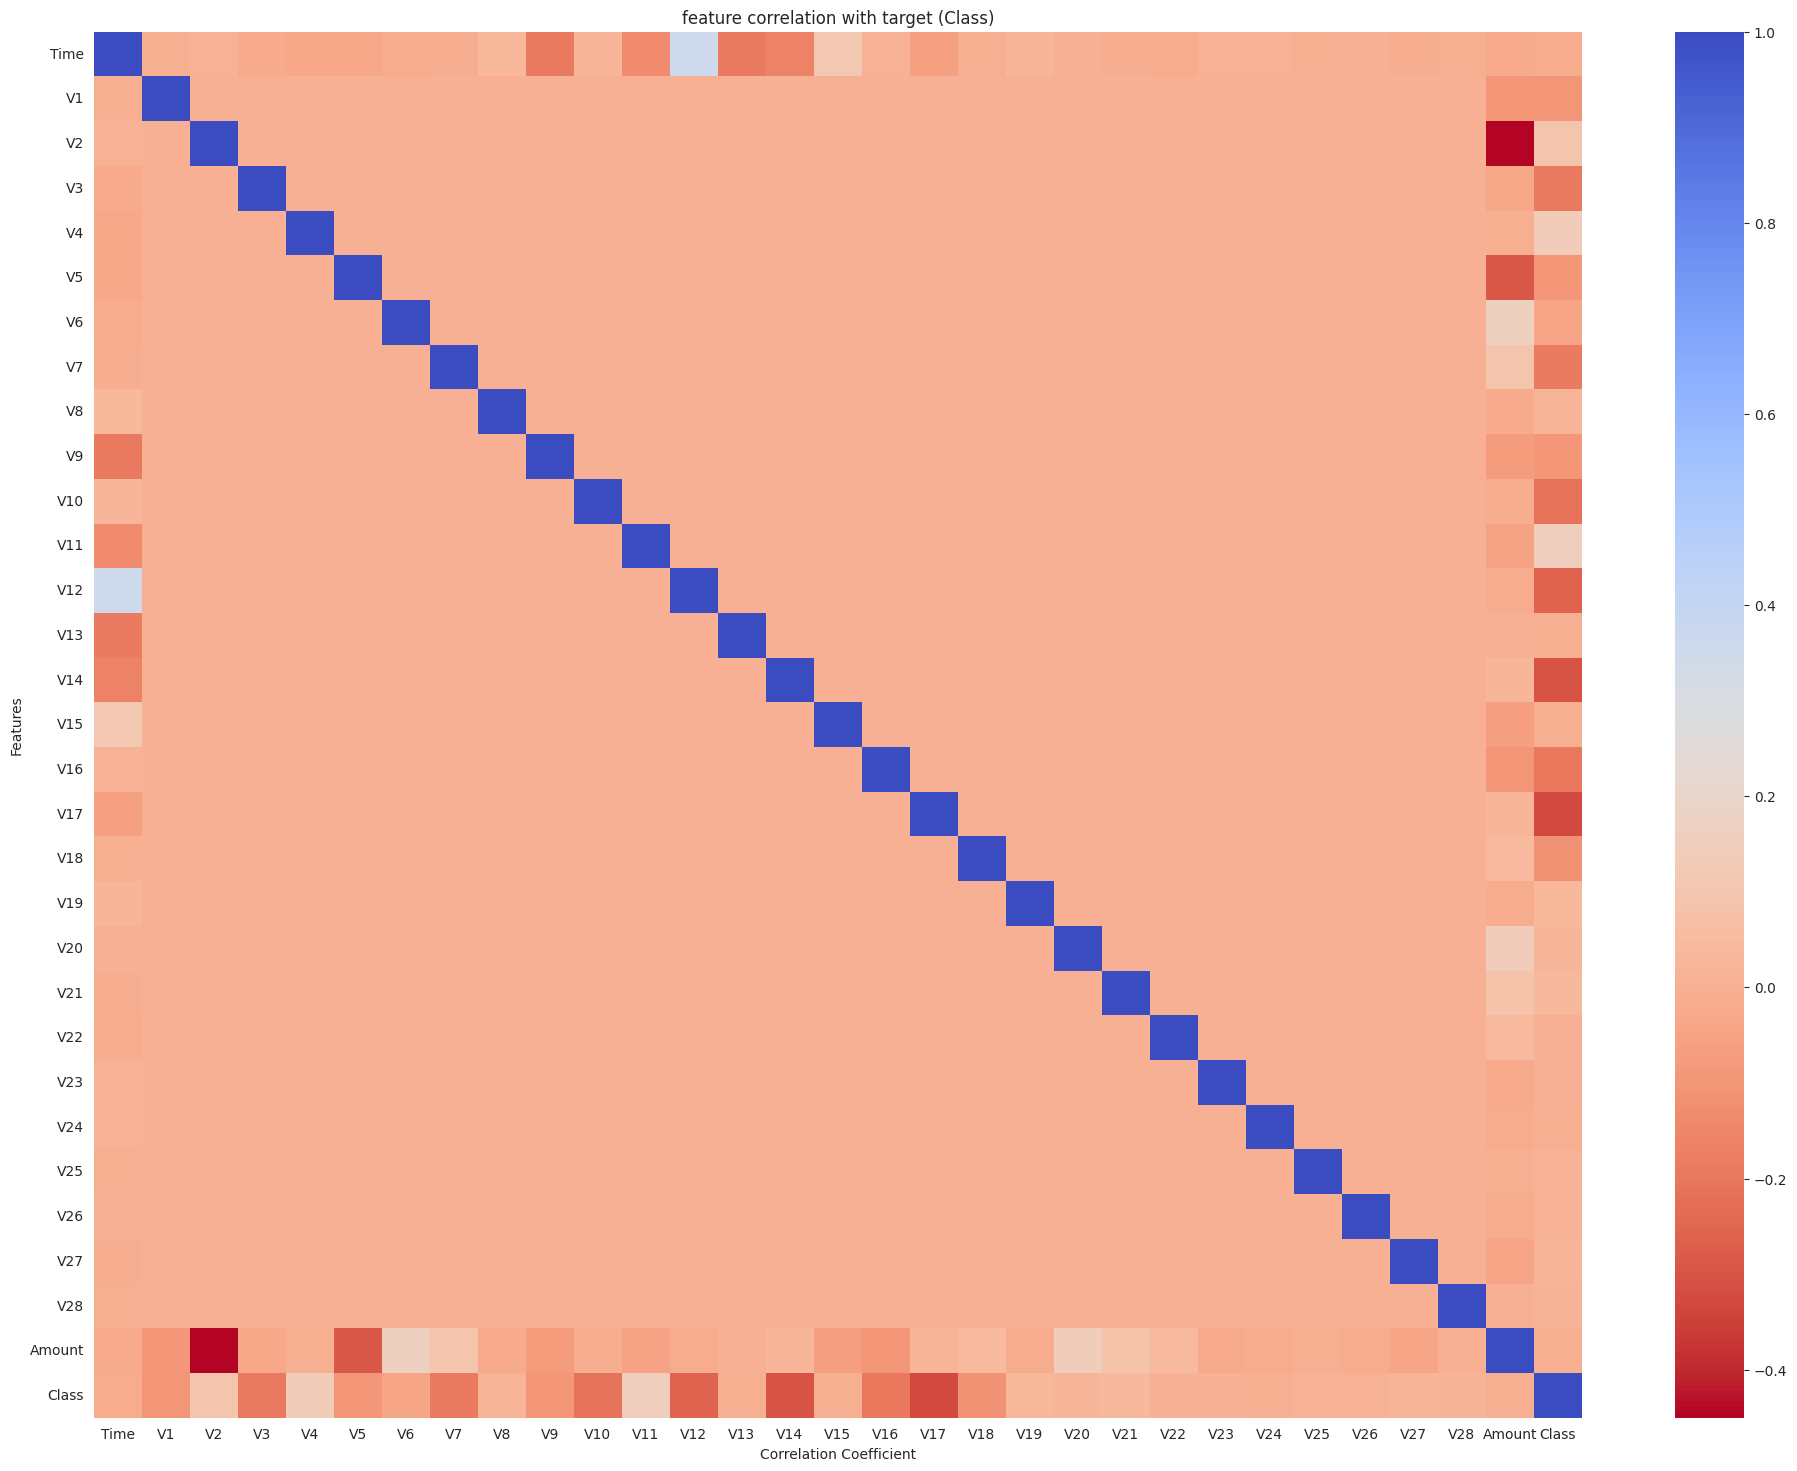

/tmp/ipython-input-2236081357.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_correlation.values, y=class_correlation.index, palette='viridis')


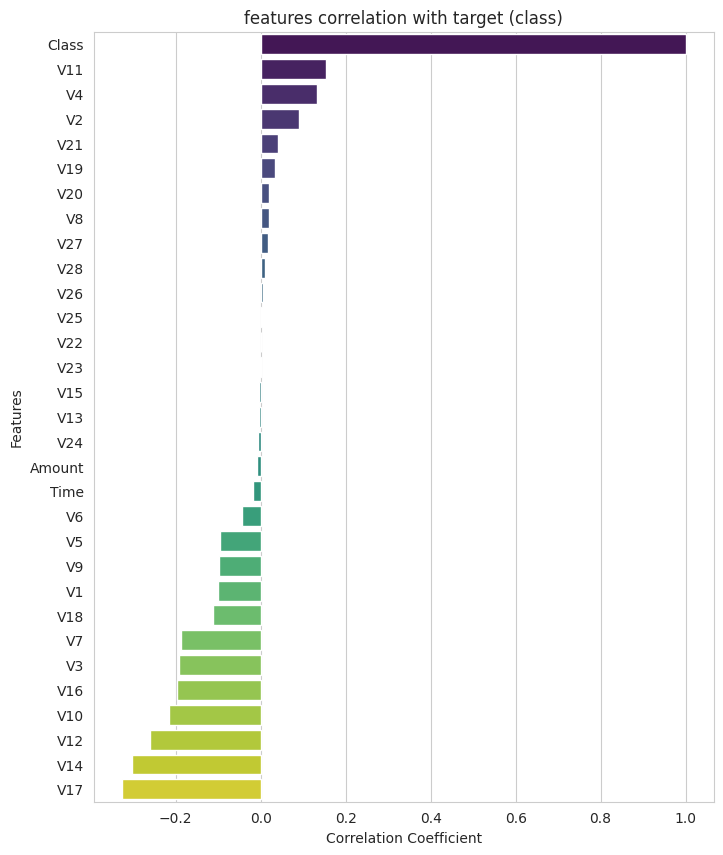

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Amount   -0.008326
Time     -0.017082
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


In [ ]:
df_corr = df.copy()
df_corr['Amount'] = np.log1p(df_corr['Amount'])
df_corr['Time']  = (df_corr['Time'] % (24*3600)) / 3600

correlation_matrix = df_corr.corr()

plt.figure(figsize=(24,18))
sns.heatmap(correlation_matrix, cmap='coolwarm_r', annot=False)
plt.title('feature correlation with target (Class)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

class_correlation = correlation_matrix['Class'].sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=class_correlation.values, y=class_correlation.index, palette='viridis')
plt.title('features correlation with target (class)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print(class_correlation)

# Preprocessing

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'],axis=1,inplace=True)

In [ ]:
x = df.drop('Class',axis=1)
y = df['Class']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

# Model Training & Hyperparameter Tuning

In [ ]:
scale_pos_weight =  y_train.value_counts()[0] / y_train.value_counts()[1]

import xgboost as xgb
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import xgboost as xgb

params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.25, 0.5]
}

kfold =  StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = make_scorer(average_precision_score)

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params,
    n_iter=50,
    scoring=scoring,
    n_jobs=1,
    cv=kfold,
    verbose=2,
    random_state=42
)

print("Starting hyperparameter tuning...")
random_search.fit(x_train, y_train)
print("Tuning finished.")

print("\n--- Best Hyperparameters Found ---")
print(random_search.best_params_)

print("\n--- Best Cross-Validation Score (Average Precision) ---")
print(f"{random_search.best_score_:.4f}")
best_model = random_search.best_estimator_

Starting hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   4.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9; total time=  25.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9; total time=  26.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9; total time=  25.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   6.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   6.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   4.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   4.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=  12.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=  12.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=  12.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:09:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.9; total time=  18.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.9; total time=  20.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.9; total time=  18.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:10:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:10:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   5.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   6.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=  11.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.9; total time=  11.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   4.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8; total time=  16.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8; total time=  16.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8; total time=  18.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   5.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:12:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  12.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  14.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:13:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.9; total time=  12.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.9; total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.9; total time=  13.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   6.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   4.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:14:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   6.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:15:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:15:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   4.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:15:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  23.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:15:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  22.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:15:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  21.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:16:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:16:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=  11.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:16:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=  11.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:17:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=  12.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:17:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  12.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:17:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  12.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:17:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  13.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:17:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   6.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:18:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=1000, subsample=0.9; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=1000, subsample=0.9; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:19:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=1000, subsample=0.9; total time=  25.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:19:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.8; total time=  12.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:19:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:19:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.8; total time=  13.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:20:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  17.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:20:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  16.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:20:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  15.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:20:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   7.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   4.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9; total time=   7.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9; total time=   9.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   6.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time=   8.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time=   8.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:22:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time=   7.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:22:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.8; total time=  25.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.8; total time=  21.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.8; total time=  23.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   6.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=0.9; total time=  16.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:24:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=0.9; total time=  16.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:24:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=0.9; total time=  23.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:24:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=  33.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=  24.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:25:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=  25.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:26:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.9; total time=  19.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:26:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.9; total time=  21.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:26:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.9; total time=  23.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:27:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=1000, subsample=0.8; total time=  34.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:27:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=1000, subsample=0.8; total time=  34.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:28:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=1000, subsample=0.8; total time=  35.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  15.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  15.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8; total time=  16.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:30:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.9; total time=   4.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:30:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.9; total time=   7.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.9; total time=  42.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:30:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.9; total time=  42.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:31:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.9; total time=  42.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:32:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.7; total time=  17.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:32:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.7; total time=  18.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:32:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.7; total time=  19.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:33:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8; total time=  27.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:33:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8; total time=  27.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8; total time=  28.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:34:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:34:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   6.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:34:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.9; total time=  22.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:35:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.9; total time=  23.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:35:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.9; total time=  24.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   6.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   6.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   4.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   8.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   5.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   8.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   7.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   9.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  10.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:37:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  15.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:37:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  15.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:37:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.25, learning_rate=0.2, max_depth=7, n_estimators=1000, subsample=1.0; total time=  15.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:37:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:38:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   7.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:38:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   9.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:38:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9; total time=  25.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:38:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9; total time=  24.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:39:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9; total time=  22.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:39:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  26.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:40:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  26.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  29.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:40:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.8; total time=  20.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:41:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.8; total time=  17.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.8; total time=  18.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuning finished.

--- Best Hyperparameters Found ---
{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}

--- Best Cross-Validation Score (Average Precision) ---
0.7446


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

print("\n--- Performance of the Tuned Model on the Test Set ---")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

final_auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"\nTest Set AUC-PR: {final_auc_pr:.4f}")


--- Performance of the Tuned Model on the Test Set ---

Confusion Matrix:
[[56851    13]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Test Set AUC-PR: 0.8730


In [ ]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_test)

# Global Explanation

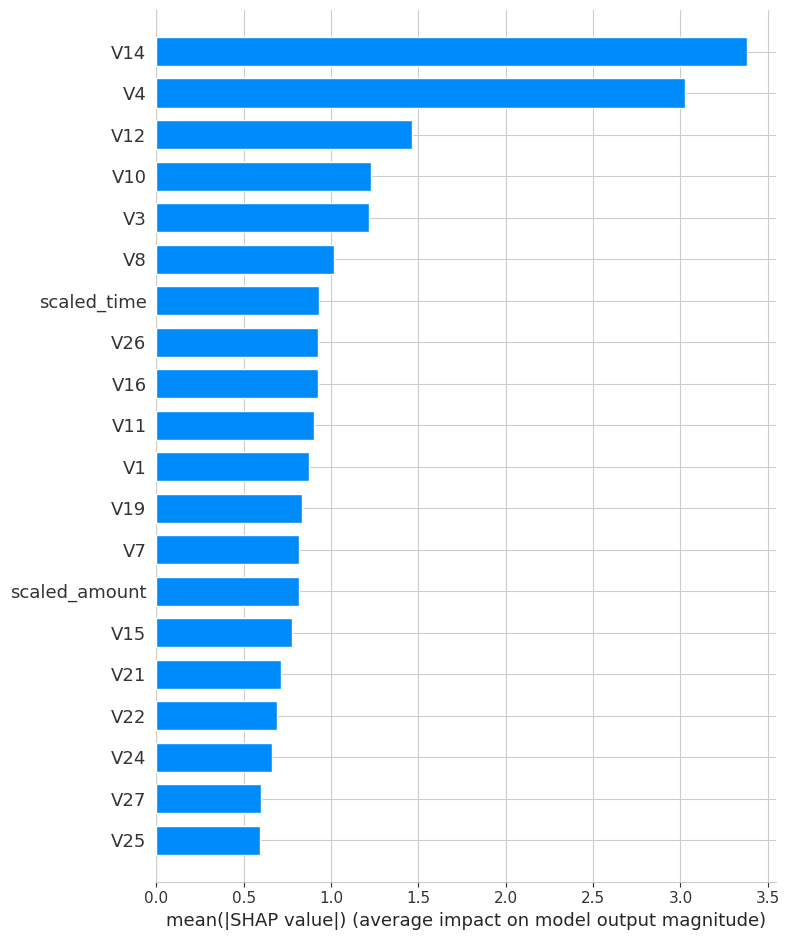

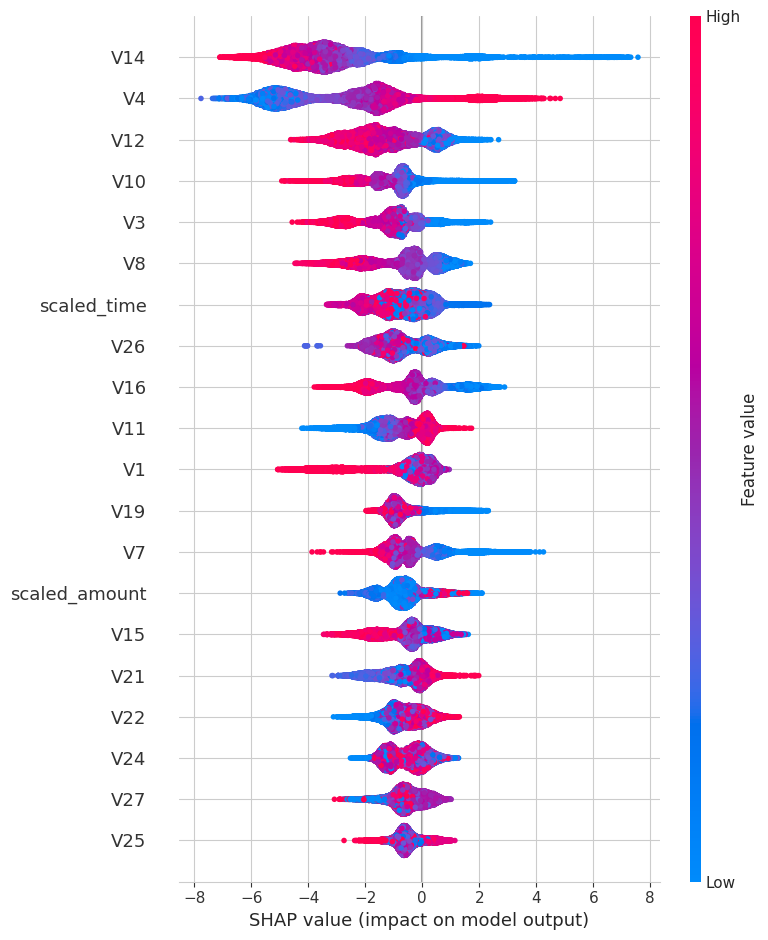

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type='bar')
shap.summary_plot(shap_values, x_test)

explanation for transaction : 10001
model prediction : Not Fraud
Fraud Probability : 0.00%


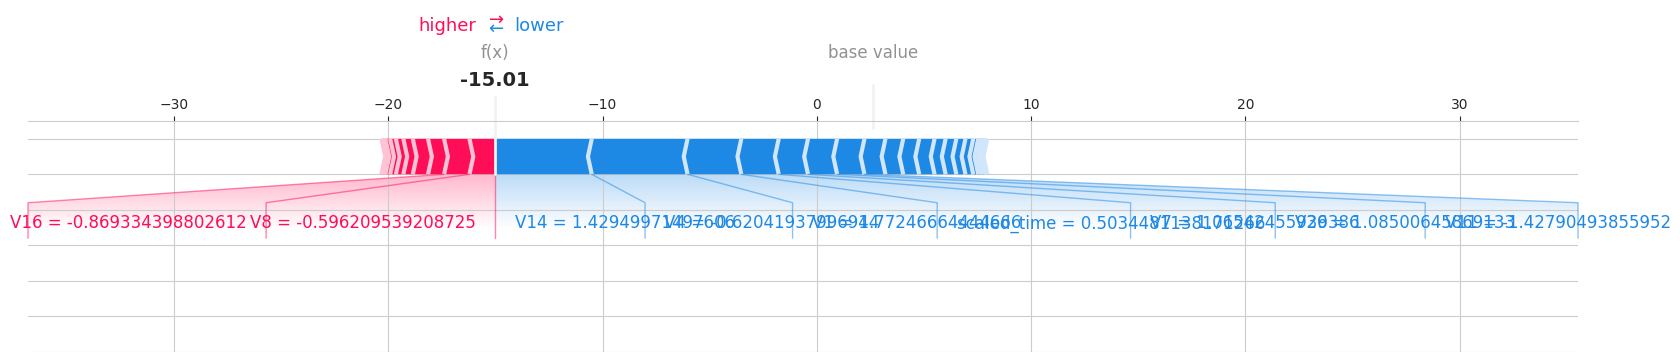

In [ ]:
def explain_prediction(transaction_index):
  print(f'explanation for transaction : {transaction_index}')
  prediction = best_model.predict(x_test.iloc[[transaction_index]])[0]
  probability = best_model.predict_proba(x_test.iloc[[transaction_index]])[0][1]

  print(f'model prediction : {'Fraud' if prediction == 1 else 'Not Fraud'}')
  print(f'Fraud Probability : {probability:.2%}')

  return shap.force_plot(explainer.expected_value, shap_values[transaction_index,:], x_test.iloc[transaction_index,:],matplotlib=True)
explain_prediction(10001)

In [ ]:
import joblib
joblib.dump(best_model,'Fraud_model.pkl')
joblib.dump(scaler,'robust_scaler.pkl')

['robust_scaler.pkl']